In [73]:
import pathlib
import json
import glob
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from pylab import rcParams
import pathlib

plt.close('all')

In [74]:
from pylab import rcParams
plt.close('all')
rcParams['figure.figsize'] = 8.0, 5.5

font_size = 20
plt.rcParams.update({'font.size': font_size, 'axes.labelsize': font_size, 'xtick.labelsize': font_size,
                    'legend.fontsize': 16,
                    'legend.handlelength': 2})


In [75]:
# a bit of an ugly hack
def namespace2dict(s):
    def device(type):
        return str(type)
    Namespace = dict
    return eval(s)

In [78]:
Experiment = namedtuple('Experiment', 
                       ['header', 'steps'])

def parse_file(fname):
    with open(fname) as f:
        for _ in range(3): f.readline()
        header = f.readline()
        header = namespace2dict(header)
        
        intervention = []
        validation = []
        
        while True:
            l = f.readline()
            if not l: break
            if 'submitit' in l: continue
                
            intervention.append(json.loads(l))
            l = f.readline()
            validation.append(json.loads(l))
    assert len(validation) == len(intervention)
    
    parsed = Experiment(header=header, steps=list(zip(validation, intervention)))
    return parsed


In [83]:
roots_gs = ['/private/home/kharitonov/nest/guess_number/2020_06_15_12_30_22/', # main text
            '/private/home/kharitonov/nest/guess_number/2020_06_15_13_22_06', # appendix
           ]

all_data_gs = []

for root in roots_gs:
    for i, fname in enumerate(pathlib.Path(root).glob('*.out')):
        try:
            parsed_data = parse_file(fname)
            all_data_gs.append(parsed_data)
        except json.JSONDecodeError as e:
            print(fname, e)
            
            
print(len(all_data_gs))


1080


In [91]:
roots_rf =  ['/private/home/kharitonov/nest/guess_number/2020_06_15_14_37_31', # main text
             '/private/home/kharitonov/nest/guess_number/2020_06_16_01_22_07/' # appendix
            ]
all_data_rf = []

for root in roots_rf:
    for i, fname in enumerate(pathlib.Path(root).glob('*.out')):
        try:
            parsed_data = parse_file(fname)
            all_data_rf.append(parsed_data)
        except json.JSONDecodeError as e:
            print(fname, e)
print(len(all_data_rf))

864


In [107]:
roots_pure =  ['/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08', # main text
              # appendix
            ]
all_data_pure = []

for root in roots_pure:
    for i, fname in enumerate(pathlib.Path(root).glob('*.out')):
        try:
            parsed_data = parse_file(fname)
            all_data_pure.append(parsed_data)
        except (SyntaxError, json.JSONDecodeError) as e:
            print(fname, e)
print(len(all_data_pure))

/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_785_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_814_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_789_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_793_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_821_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_825_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08/27503360_799_0_log.out unexpected EOF while parsing (<string>, line 0)
/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08

In [108]:
all_data_pure[0]

Experiment(header={'batch_size': 2048, 'bits_r': 0, 'bits_s': 8, 'checkpoint_dir': '/private/home/kharitonov/nest/guess_number/2020_06_16_10_30_08', 'checkpoint_freq': 1, 'cuda': True, 'device': 'cuda', 'dump_language': False, 'early_stopping_thr': 0.99, 'load_from_checkpoint': None, 'lr': 0.001, 'max_len': 1, 'mode': 'non_diff', 'n_bits': 8, 'n_epochs': 1000, 'n_examples_per_epoch': 2048000, 'no_cuda': False, 'optimizer': 'adam', 'preemptable': True, 'random_seed': 0, 'receiver_cell': 'rnn', 'receiver_emb': 10, 'receiver_entropy_coeff': 0.1, 'receiver_hidden': 30, 'receiver_lr': 0.001, 'sender_cell': 'rnn', 'sender_emb': 10, 'sender_entropy_coeff': 0.01, 'sender_hidden': 30, 'sender_lr': 0.001, 'temperature': 1.0, 'tensorboard': False, 'tensorboard_dir': 'runs/', 'validation_freq': 1, 'variable_length': False, 'vocab_size': 1024}, steps=[({'mode': 'test', 'epoch': 1, 'loss': -0.0078125, 'acc': 0.0078125, 'baseline': -0.003925292968749997, 'sender_entropy': 6.925200939178467, 'receiver

## Experiment 1: Bits needed vs Bits transmitted

In [109]:
receiver_bits = list(range(9))


def get_stats(dataset):
    intervention_acc_gs = dict((z, []) for z in receiver_bits)


    bits_sent = dict((z, []) for z in receiver_bits)
    code_entropy = dict((z, []) for z in receiver_bits)

    for data in dataset:
        if len(data.steps) == 0:
            continue

        header = data.header
        bits_shown = header['bits_r']

        take_step = data.steps[-1]
        validation, intervention = take_step

        intervention_message = intervention['intervention_message']
        intervention_input = intervention['input_intervention']

        if validation['acc'] >= 0.99:
            intervention_accuracy = intervention_message['mean_acc']
            intervention_acc_gs[bits_shown].append(intervention_accuracy)

            message_info = intervention_message['message_info']
            bits_sent[bits_shown].append(message_info) 
            code_entropy[bits_shown].append(intervention['validation']['codewords_entropy'])

            
    return dict(
        intervention_acc_gs=intervention_acc_gs, \
        bits_sent=bits_sent, \
        code_entropy=code_entropy)

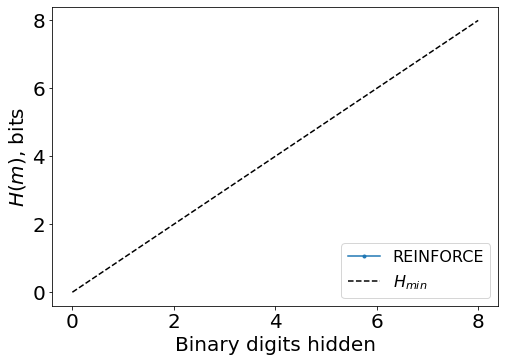

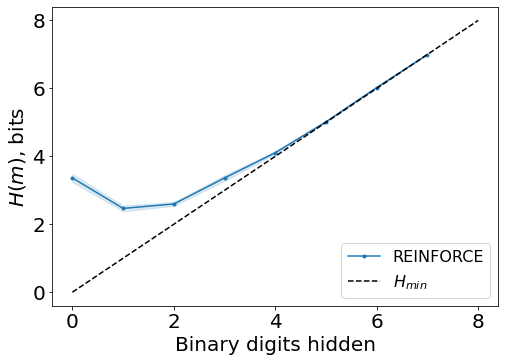

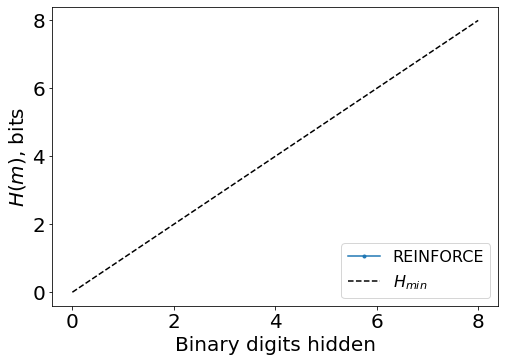

In [111]:
values = receiver_bits

for vocab_size in [256, 1024, 4096]:
    filtered_by_vocab_gs = [d for d in all_data_gs if d.header['vocab_size'] == vocab_size]
    gs_filtered_results = get_stats(filtered_by_vocab_gs)
    
    filtered_by_vocab_rf = [d for d in all_data_rf if d.header['vocab_size'] == vocab_size]
    rf_filtered_results = get_stats(filtered_by_vocab_rf)
    
    filtered_by_vocab_pure = [d for d in all_data_pure if d.header['vocab_size'] == vocab_size]
    pure_filtered_results = get_stats(filtered_by_vocab_pure)
    
    for name, bits_sent in [
        #('Gumbel-Softmax', gs_filtered_results['bits_sent']),
        #('Stoch. computation', rf_filtered_results['bits_sent']),
        ('REINFORCE', pure_filtered_results['bits_sent']),
        ]:

        means = [None for _ in values]
        stds = [None for _ in values]


        for i, v in enumerate(values):
            if len(bits_sent[v]) > 0:
                n = len(bits_sent[v])
                means[i] = np.mean(bits_sent[v])
                stds[i] = np.std(bits_sent[v]) /  np.sqrt(n)

        x, y, e, = [], [], []

        for _x, _y, _e in zip(values, means, stds):
            if _y is None:
                continue
            x.append(_x)
            y.append(_y)
            e.append(_e)

        x = np.array(x)
        y = np.array(y)
        e = np.array(e)

        x = 8 - x
        p = plt.plot(x, y, linestyle='-', marker='.', label=name)
        plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())


    plt.plot(list(range(9)), list(range(9)), linestyle='--', label="$H_{min}$", color='black')

    plt.legend(loc="lower right")
    plt.ylabel("$H(m)$, bits")
    plt.xlabel("Binary digits hidden")
    #plt.savefig(f'guess_pics_new/pooled_info_{vocab_size}.pdf')

    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'guess_pics_new/hot_cold_info_256.pdf'

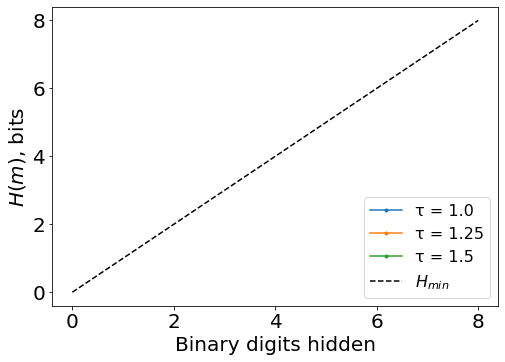

In [81]:
temps = set(x.header['temperature'] for x in all_data_gs)

values = receiver_bits

for vocab_size in [256, 1024, 4096]:
    filtered_by_vocab = [d for d in all_data_gs if d.header['vocab_size'] == vocab_size]
    #filtered_results = get_stats(filtered_by_vocab)

    by_temp = {}

    for t in temps:
        _data = [x for x in filtered_by_vocab if x.header['temperature'] == t]
        by_temp[t] = get_stats(_data)
    
    
    for t in sorted(list(temps)):
        if t in [0.75, 0.5]: continue
            
        name = f"τ = {t}"
        intervention_acc = by_temp[t]['bits_sent']

        acc_mean = [None for _ in values]
        acc_stds = [None for _ in values]


        for i, v in enumerate(values):
            if len(intervention_acc[v]) > 0:
                n = len(intervention_acc[v])
                acc_mean[i] = np.mean(intervention_acc[v])
                acc_stds[i] = np.std(intervention_acc[v]) /  np.sqrt(n)

        x, y, e, = [], [], []

        for _x, _y, _e in zip(values, acc_mean, acc_stds):
            if _y is None:
                continue
            x.append(_x)
            y.append(_y)
            e.append(_e)

        x = np.array(x)
        y = np.array(y)
        e = np.array(e)

        x = 8 - x
        p = plt.plot(x, y, linestyle='-', marker='.', label=name)
        plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())


    plt.plot(list(range(9)), list(range(9)), linestyle='--', label="$H_{min}$", color='black')

    plt.legend(loc="lower right")
    plt.ylabel("$H(m)$, bits")
    plt.xlabel("Binary digits hidden")
    plt.savefig(f'guess_pics_new/hot_cold_info_{vocab_size}.pdf')

    plt.show()

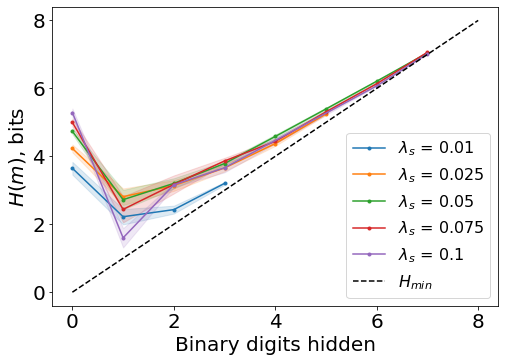

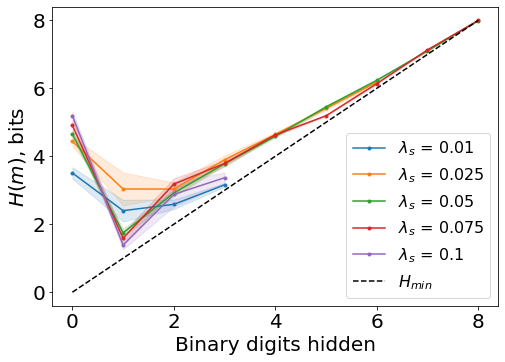

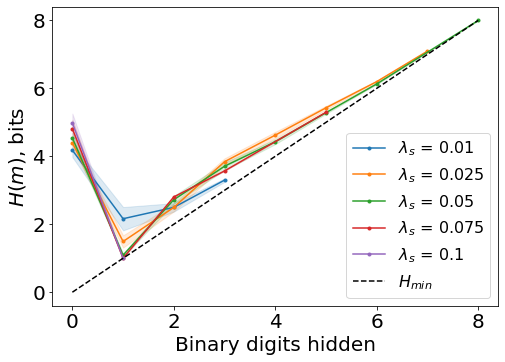

In [33]:
lambdae = set(x.header['sender_entropy_coeff'] for x in all_data_rf)
values = receiver_bits

for vocab_size in [256, 1024, 4096]:
    filtered_by_vocab = [d for d in all_data_rf if d.header['vocab_size'] == vocab_size]

    by_lambda = {}

    for l in lambdae:
        _data = [x for x in filtered_by_vocab if x.header['sender_entropy_coeff'] == l]
        by_lambda[l] = get_stats(_data)
    
    
    for l in sorted(list(lambdae)):
        if l >= 0.25: continue
        name = f"$\lambda_s$ = {l}"
        intervention_acc = by_lambda[l]['bits_sent']

        acc_mean = [None for _ in values]
        acc_stds = [None for _ in values]


        for i, v in enumerate(values):
            if len(intervention_acc[v]) > 0:
                n = len(intervention_acc[v])
                acc_mean[i] = np.mean(intervention_acc[v])
                acc_stds[i] = np.std(intervention_acc[v]) /  np.sqrt(n)

        x, y, e, = [], [], []

        for _x, _y, _e in zip(values, acc_mean, acc_stds):
            if _y is None:
                continue
            x.append(_x)
            y.append(_y)
            e.append(_e)

        x = np.array(x)
        y = np.array(y)
        e = np.array(e)

        x = 8 - x
        p = plt.plot(x, y, linestyle='-', marker='.', label=name)
        plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())


    plt.plot(list(range(9)), list(range(9)), linestyle='--', label="$H_{min}$", color='black')

    plt.legend(loc="lower right")
    plt.ylabel("$H(m)$, bits")
    plt.xlabel("Binary digits hidden")
    plt.savefig(f'guess_pics_new/rf_by_l_{vocab_size}.pdf')

    plt.show()

In [34]:
all_data_pure[0].header

{'n_bits': 8,
 'bits_s': 8,
 'bits_r': 0,
 'n_examples_per_epoch': 2048000,
 'sender_hidden': 30,
 'receiver_hidden': 30,
 'temperature': 1.0,
 'sender_entropy_coeff': 0.01,
 'receiver_entropy_coeff': 0.01,
 'sender_lr': 0.0001,
 'receiver_lr': 0.0001,
 'mode': 'non_diff',
 'early_stopping_thr': 0.99,
 'random_seed': 0,
 'checkpoint_dir': '/private/home/kharitonov/nest/guess_number/2019_05_15_07_28_37',
 'preemptable': True,
 'checkpoint_freq': 500,
 'validation_freq': 1,
 'n_epochs': 1000,
 'load_from_checkpoint': None,
 'no_cuda': False,
 'batch_size': 2048,
 'optimizer': 'adam',
 'lr': 0.0001,
 'vocab_size': 256,
 'max_len': 1,
 'cuda': True,
 'device': 'cuda'}

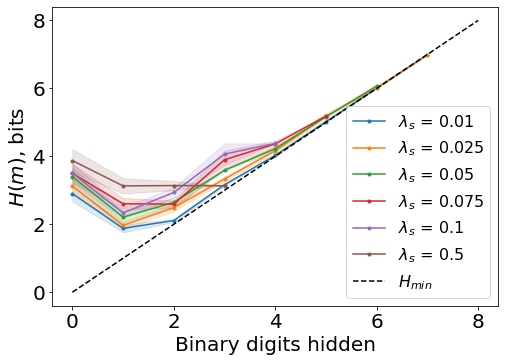

In [40]:
lambdae = set(x.header['sender_entropy_coeff'] for x in all_data_pure)
values = receiver_bits

for vocab_size in [1024]:#[256, 512, 1024, 4096]:
    filtered_by_vocab = [d for d in all_data_pure if d.header['vocab_size'] == vocab_size]

    by_lambda = {}

    for l in lambdae:
        _data = [x for x in filtered_by_vocab if x.header['sender_entropy_coeff'] == l]
        by_lambda[l] = get_stats(_data)
    
    
    for l in sorted(list(lambdae)):
        if l >= 1: continue
        
        name = f"$\lambda_s$ = {l}"
        intervention_acc = by_lambda[l]['bits_sent']

        acc_mean = [None for _ in values]
        acc_stds = [None for _ in values]


        for i, v in enumerate(values):
            if len(intervention_acc[v]) > 0:
                n = len(intervention_acc[v])
                acc_mean[i] = np.mean(intervention_acc[v])
                acc_stds[i] = np.std(intervention_acc[v]) /  np.sqrt(n)

        x, y, e, = [], [], []

        for _x, _y, _e in zip(values, acc_mean, acc_stds):
            if _y is None:
                continue
            x.append(_x)
            y.append(_y)
            e.append(_e)

        x = np.array(x)
        y = np.array(y)
        e = np.array(e)

        x = 8 - x
        p = plt.plot(x, y, linestyle='-', marker='.', label=name)
        plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())


    plt.plot(list(range(9)), list(range(9)), linestyle='--', label="$H_{min}$", color='black')

    plt.legend(loc="lower right")
    plt.ylabel("$H(m)$, bits")
    plt.xlabel("Binary digits hidden")
    plt.savefig(f'guess_pics_new/pure_by_l_{vocab_size}.pdf')

    plt.show()

In [255]:
all_data_rf = [x for x in all_data_rf if x.header['batch_size'] == 2048]

In [65]:
lambdae

{0.01, 0.05, 0.25}

In [256]:
by_lambda = {}

for l in lambdae:
    _data = [x for x in all_data_rf if x.header['sender_entropy_coeff'] == l]
    by_lambda[l] = get_stats(_data)

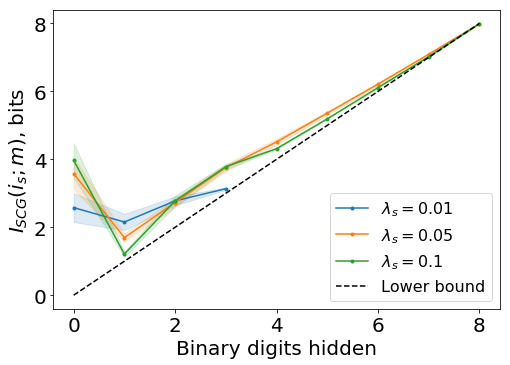

In [265]:
values = receiver_bits

#for name, intervention_acc in [
#                             ('$I_{RFD}(a; m), \lambda_A > 0.05$', high_results['bits_sent']),
#                             ('$I_{RFD}(a; m)$, $\lambda_A$ ≤ 0.05', low_results['bits_sent']),
#                            ]:
for l in sorted(list(lambdae)):
    if l in [0.25, 1, 0.5, 0.001]: continue
        
    name = f'$\lambda_s = {l}$'
    intervention_acc = by_lambda[l]['bits_sent']
    
    acc_mean = [None for _ in values]
    acc_stds = [None for _ in values]


    for i, v in enumerate(values):
        if len(intervention_acc[v]) > 0:
            n = len(intervention_acc[v])
            acc_mean[i] = np.mean(intervention_acc[v])
            acc_stds[i] = np.std(intervention_acc[v]) /  np.sqrt(n)

    x, y, e, = [], [], []

    for _x, _y, _e in zip(values, acc_mean, acc_stds):
        if _y is None:
            continue
        x.append(_x)
        y.append(_y)
        e.append(_e)
        
    x = np.array(x)
    y = np.array(y)
    e = np.array(e)

    x = 8 - x
    p = plt.plot(x, y, linestyle='-', marker='.', label=name)
    plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())
    
plt.plot(list(range(9)), list(range(9)), linestyle='--', label="Lower bound", color='black')
#plt.plot(list(range(9)), [8]*9, linestyle='-.', label="Upper bound, $H(i_s)$", color='black')

    
plt.legend(loc="lower right")
plt.ylabel("$I_{SCG}(i_s; m)$, bits")
plt.xlabel("Binary digits hidden")
plt.savefig('guess_pics/high_low_diff_info.pdf')

plt.show()

In [249]:
lambdae = set(x.header['sender_entropy_coeff'] for x in all_data_rf)

by_lambda_pure = {}

for l in lambdae:
    _data = [x for x in all_data_pure if x.header['sender_entropy_coeff'] == l]
    by_lambda_pure[l] = get_stats(_data)
    


#high_entropy_data = [x for x in all_data_pure if x.header['sender_entropy_coeff'] > 0.05]
#high_results = get_stats(high_entropy_data)

#low_entropy_data = [x for x in all_data_pure if x.header['sender_entropy_coeff'] <= 0.05]
#low_results = get_stats(low_entropy_data)

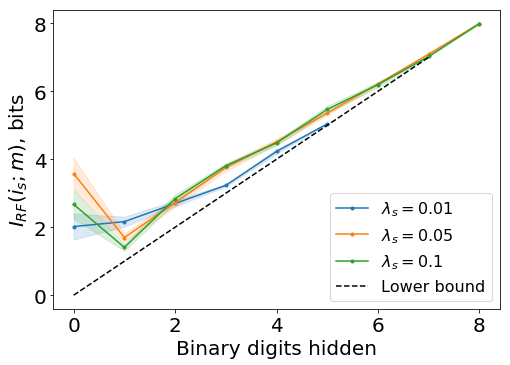

In [266]:
values = receiver_bits

#for name, intervention_acc in [
#                             ('$I_{RFN}(a; m), \lambda_A > 0.05$', high_results['bits_sent']),
#                             ('$I_{RFN}(a; m)$, $\lambda_A$ ≤ 0.05', low_results['bits_sent']),
#                            ]:
for l in sorted(list(lambdae)):
    if l in [0.25, 1, 0.5, 0.001]: continue
        
    name = f'$\lambda_s = {l}$'
    intervention_acc = by_lambda_pure[l]['bits_sent']
    
    acc_mean = [None for _ in values]
    acc_stds = [None for _ in values]


    for i, v in enumerate(values):
        if len(intervention_acc[v]) > 0:
            n = len(intervention_acc[v])
            acc_mean[i] = np.mean(intervention_acc[v])
            acc_stds[i] = np.std(intervention_acc[v]) /  np.sqrt(n)

    x, y, e, = [], [], []

    for _x, _y, _e in zip(values, acc_mean, acc_stds):
        if _y is None:
            continue
        x.append(_x)
        y.append(_y)
        e.append(_e)
        
    x = np.array(x)
    y = np.array(y)
    e = np.array(e)

    x = 8 - x
    p = plt.plot(x, y, linestyle='-', marker='.', label=name)
    plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())
    
plt.plot(list(range(8)), list(range(8)), linestyle='--', label="Lower bound", color='black')

    
plt.legend(loc="lower right")
plt.ylabel("$I_{RF}(i_s; m)$, bits")
plt.xlabel("Binary digits hidden")
plt.savefig('guess_pics/high_low_no_diff_info.pdf')

plt.show()

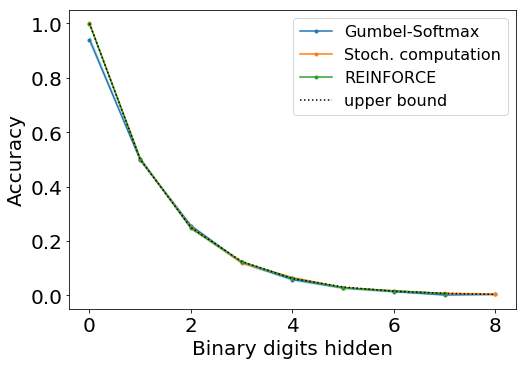

In [180]:
values = receiver_bits

for vocab_size in [1024]:
    filtered_by_vocab_gs = [d for d in all_data_gs if d.header['vocab_size'] == vocab_size]
    gs_filtered_results = get_stats(filtered_by_vocab_gs)

    filtered_by_vocab_rf = [d for d in all_data_rf if d.header['vocab_size'] == vocab_size]
    rf_filtered_results = get_stats(filtered_by_vocab_rf)
    
    filtered_by_vocab_pure = [d for d in all_data_pure if d.header['vocab_size'] == vocab_size]
    pure_filtered_results = get_stats(filtered_by_vocab_pure)
    
    for name, intervention_acc in [
        ('Gumbel-Softmax', gs_filtered_results['intervention_acc_gs']),
        ('Stoch. computation', rf_filtered_results['intervention_acc_gs']),
        ('REINFORCE', pure_filtered_results['intervention_acc_gs']),
        
        ]:

        acc_mean = [None for _ in values]
        acc_stds = [None for _ in values]


        for i, v in enumerate(values):
            if len(intervention_acc[v]) > 0:
                n = len(intervention_acc[v])
                acc_mean[i] = np.mean(intervention_acc[v])
                acc_stds[i] = np.std(intervention_acc[v]) /  np.sqrt(n)

        x, y, e, = [], [], []

        for _x, _y, _e in zip(values, acc_mean, acc_stds):
            if _y is None:
                continue
            x.append(_x)
            y.append(_y)
            e.append(_e)

        x = np.array(x)
        y = np.array(y)
        e = np.array(e)

        x = 8 - x
        p = plt.plot(x, y, linestyle='-', marker='.', label=name)
        plt.fill_between(x, y-e, y+e, alpha=0.15, color=p[0].get_color())


    plt.plot(list(range(9)), 2.0**(-np.array(list(range(9)))), linestyle=':', label="upper bound", color='black')

    plt.legend(loc="upper right")
    plt.ylabel("Accuracy")
    plt.xlabel("Binary digits hidden")
    plt.savefig(f'guess_pics/intervention_pooled_{vocab_size}.pdf')

    plt.show()